# Welcome to the Quick Draw Image Recognition Notebook! 🎨

This notebook introduces you to fundamental concepts in Applied Machine Learning, specifically focusing on **image classification** using **Convolutional Neural Networks (CNNs)**.

## What You Will Learn:

*   **Data Preparation**: Discover how to work with and prepare the fun and illustrative [Quick Draw dataset](https://quickdraw.withgoogle.com/data).
*   **Model Building**: Learn to construct and train neural network models, including basic and more advanced CNN architectures.
*   **Training with Different Optimizers**: Compare how SGD, Adam, RMSprop, and other optimizers affect learning.
*   **Model Evaluation**: Understand key metrics and techniques to assess and compare the performance of your machine learning models.
*   **Interactive Deployment**: Implement an interactive web interface using `Gradio` to deploy and demonstrate your trained model.

Our goal is to understand the entire pipeline of building a machine learning application, from data acquisition and model training to interactive deployment. Let's get started!

---

### ⚙️ Setting Up Your Environment

Before we dive into the machine learning tasks, we need to ensure our environment has all the required tools.

In [1]:
# ============================================================
# CELL 1: Install and Import Dependencies
# ============================================================
# We install the required libraries:
# - gradio: for building interactive web interfaces
# - torch, torchvision: PyTorch deep learning framework
# - matplotlib, seaborn: for visualizations
# - requests: for downloading data from the web

!pip install gradio torch torchvision matplotlib seaborn requests -q

import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
import io
import time
from collections import defaultdict

# Set random seeds for reproducibility
# This ensures that our experiments can be replicated
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available (training will be faster on GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the classes we'll be classifying
# These are categories from the Quick Draw dataset
CLASSES = ['cat', 'dog', 'house', 'tree', 'car', 'sun', 'flower', 'bird', 'fish', 'star']
print(f"Classes to recognize: {CLASSES}")

Using device: cpu
Classes to recognize: ['cat', 'dog', 'house', 'tree', 'car', 'sun', 'flower', 'bird', 'fish', 'star']


---
## 📥 Step 1: Download and Prepare the Quick Draw Dataset

The Quick Draw dataset contains millions of doodles collected from players of the Quick, Draw! game.
Each drawing is stored as a 28x28 grayscale image (same size as MNIST digits).

**Key concepts:**
- We download raw `.npy` files from Google's storage
- Each file contains thousands of 28x28 pixel drawings
- We'll use a subset (configurable) for faster training

In [2]:
# ============================================================
# CELL 2: Data Download Functions
# ============================================================

def download_quickdraw_class(class_name, max_samples=5000):
    """
    Download Quick Draw data for a single class.

    Args:
        class_name: The category to download (e.g., 'cat', 'dog')
        max_samples: Maximum number of samples to use (limits memory usage)

    Returns:
        numpy array of shape (n_samples, 28, 28) containing grayscale images

    The data is stored at Google's Quick Draw storage bucket.
    Each .npy file contains drawings as 28x28 uint8 arrays.
    """
    # Google's public URL for Quick Draw numpy files
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    url = f"{base_url}{class_name}.npy"

    print(f"  Downloading {class_name}...", end=" ")

    try:
        # Download the numpy file
        response = requests.get(url)
        response.raise_for_status()  # Raise error if download failed

        # Load numpy array from bytes
        data = np.load(io.BytesIO(response.content))

        # Limit samples to reduce memory and training time
        # Shuffle first to get random samples
        np.random.shuffle(data)
        data = data[:max_samples]

        # Reshape from flat (784,) to image (28, 28)
        data = data.reshape(-1, 28, 28)

        print(f"✓ ({len(data)} samples)")
        return data

    except Exception as e:
        print(f"✗ Error: {e}")
        return None


def load_quickdraw_dataset(classes, samples_per_class=5000):
    """
    Load the complete Quick Draw dataset for all specified classes.

    Args:
        classes: List of class names to download
        samples_per_class: Number of samples per class

    Returns:
        X: numpy array of images, shape (n_total, 28, 28)
        y: numpy array of labels, shape (n_total,)
    """
    print(f"\n📥 Loading Quick Draw dataset ({len(classes)} classes, {samples_per_class} samples each)...\n")

    all_images = []
    all_labels = []

    for class_idx, class_name in enumerate(classes):
        # Download data for this class
        images = download_quickdraw_class(class_name, samples_per_class)

        if images is not None:
            all_images.append(images)
            # Create labels (class index repeated for each sample)
            all_labels.append(np.full(len(images), class_idx))

    # Concatenate all classes
    X = np.concatenate(all_images, axis=0)
    y = np.concatenate(all_labels, axis=0)

    # Shuffle the entire dataset
    # This is important! Without shuffling, the model would see all cats,
    # then all dogs, etc., which can hurt learning.
    shuffle_idx = np.random.permutation(len(X))
    X = X[shuffle_idx]
    y = y[shuffle_idx]

    print(f"\n✅ Dataset loaded: {X.shape[0]} total samples")
    print(f"   Image shape: {X.shape[1:]} (28x28 grayscale)")
    print(f"   Classes: {len(np.unique(y))}")

    return X, y


# Download the dataset
# Using 3000 samples per class for reasonable training time
X_data, y_data = load_quickdraw_dataset(CLASSES, samples_per_class=3000)


📥 Loading Quick Draw dataset (10 classes, 3000 samples each)...


✅ Dataset loaded: 30000 total samples
   Image shape: (28, 28) (28x28 grayscale)
   Classes: 10


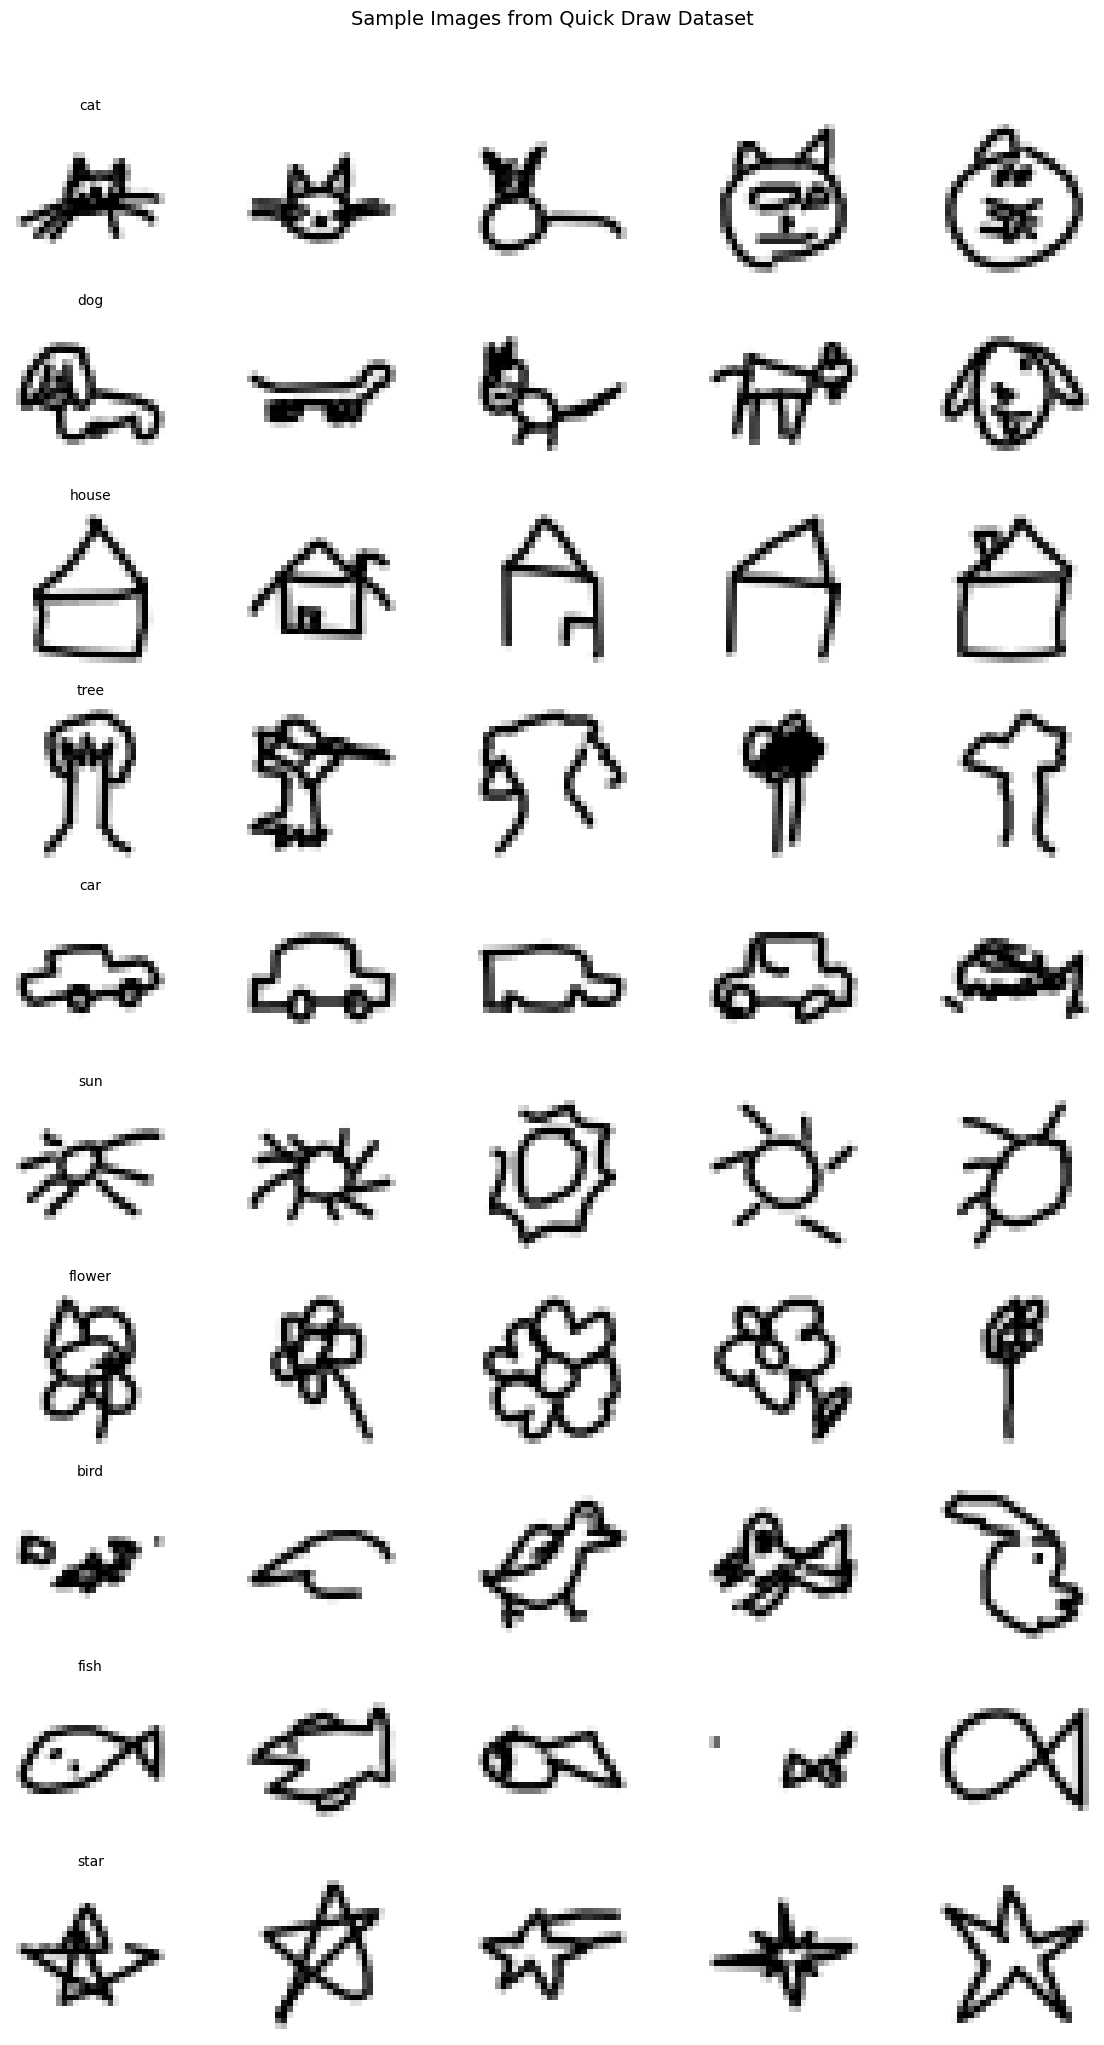

In [3]:
# ============================================================
# CELL 3: Visualize Sample Data
# ============================================================
# Let's look at some examples from our dataset to understand what we're working with

def visualize_samples(X, y, classes, n_per_class=5):
    """
    Display sample images from each class.

    This is an important step in any ML project - always visualize your data
    to ensure it looks correct and to understand what the model needs to learn.
    """
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(12, 2*n_classes))

    for class_idx, class_name in enumerate(classes):
        # Find indices of this class
        class_indices = np.where(y == class_idx)[0]
        # Randomly select n_per_class samples
        sample_indices = np.random.choice(class_indices, n_per_class, replace=False)

        for i, idx in enumerate(sample_indices):
            axes[class_idx, i].imshow(X[idx], cmap='gray_r')  # gray_r for white background
            axes[class_idx, i].axis('off')
            if i == 0:
                axes[class_idx, i].set_title(class_name, fontsize=10)

    plt.suptitle('Sample Images from Quick Draw Dataset', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples(X_data, y_data, CLASSES)

---
## 🧠 Step 2: Define the Neural Network Model

We'll use a Convolutional Neural Network (CNN) - the go-to architecture for image classification.

**Why CNNs for images?**
- They detect local patterns (edges, shapes) regardless of position
- They're parameter-efficient through weight sharing
- They build hierarchical representations (edges → shapes → objects)

In [4]:
# ============================================================
# CELL 4: Model Definition
# ============================================================

class SimpleCNN(nn.Module):
    """
    A simple CNN for sketch classification.

    Architecture:
    - 3 convolutional blocks (conv -> batchnorm -> relu -> pool)
    - 1 fully connected layer for classification

    Each convolutional layer learns different features:
    - Layer 1: Low-level features (edges, corners)
    - Layer 2: Mid-level features (shapes, curves)
    - Layer 3: High-level features (parts of objects)
    """

    def __init__(self, num_classes=10):
        super().__init__()

        # ---- Convolutional Block 1 ----
        # Input: 1x28x28 (1 channel grayscale, 28x28 pixels)
        # Output: 16x14x14 (16 feature maps, halved by pooling)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Normalizes activations for stable training
        self.pool1 = nn.MaxPool2d(2)    # Reduces spatial dimensions by 2x

        # ---- Convolutional Block 2 ----
        # Input: 16x14x14
        # Output: 32x7x7
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        # ---- Convolutional Block 3 ----
        # Input: 32x7x7
        # Output: 64x1x1 (global average pooling reduces to single value per channel)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AdaptiveAvgPool2d(1)  # Global average pooling

        # ---- Classification Head ----
        # Input: 64 features
        # Output: num_classes scores (logits)
        self.fc = nn.Linear(64, num_classes)

        # Store activations for visualization (teaching purposes)
        self.activations = {}

    def forward(self, x, store_activations=False):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)
            store_activations: If True, save intermediate activations for visualization

        Returns:
            Logits tensor of shape (batch_size, num_classes)
        """
        # Block 1: Edge detection
        x = self.conv1(x)
        if store_activations:
            self.activations['conv1'] = x.detach()
        x = F.relu(self.bn1(x))  # ReLU activation: max(0, x)
        x = self.pool1(x)

        # Block 2: Shape detection
        x = self.conv2(x)
        if store_activations:
            self.activations['conv2'] = x.detach()
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        # Block 3: Part detection
        x = self.conv3(x)
        if store_activations:
            self.activations['conv3'] = x.detach()
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        # Flatten and classify
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64)
        x = self.fc(x)

        return x


# Test the model with a random input
test_model = SimpleCNN(num_classes=len(CLASSES))
test_input = torch.randn(1, 1, 28, 28)  # Batch of 1 image
test_output = test_model(test_input)
print(f"Model architecture:\n{test_model}")
print(f"\nInput shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Model architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Input shape:  torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10])

Total parameters: 24,170


---
## 🏋️ Step 3: Training with Different Optimizers

**What is an Optimizer?**

An optimizer is the algorithm that updates the model's weights based on the computed gradients. Different optimizers have different strategies:

| Optimizer | Key Idea | Pros | Cons |
|-----------|----------|------|------|
| **SGD** | Simple gradient descent | Stable, good for generalization | Slow, sensitive to learning rate |
| **SGD+Momentum** | Adds velocity to updates | Faster than plain SGD | Extra hyperparameter |
| **Adam** | Adaptive learning rates per parameter | Fast convergence, robust | May generalize worse |
| **RMSprop** | Adapts based on recent gradients | Good for non-stationary problems | Less common now |
| **AdamW** | Adam with proper weight decay | Better generalization than Adam | Slightly more complex |

Let's train with each and compare!

In [5]:
# ============================================================
# CELL 5: Data Preparation and Training Function
# ============================================================

def prepare_data_loaders(X, y, train_ratio=0.8, batch_size=64):
    """
    Prepare PyTorch DataLoaders with train/test split.

    IMPORTANT: We split data into training and test sets to evaluate
    how well the model generalizes to unseen data. Training accuracy
    alone can be misleading (the model might just memorize the data).

    Args:
        X: Image data, shape (n_samples, 28, 28)
        y: Labels, shape (n_samples,)
        train_ratio: Fraction of data for training (rest is for testing)
        batch_size: Number of samples per batch during training

    Returns:
        train_loader, test_loader: PyTorch DataLoader objects
    """
    # Normalize pixel values to [0, 1] range
    # Neural networks work better with normalized inputs
    X_normalized = X.astype(np.float32) / 255.0

    # Add channel dimension: (N, 28, 28) -> (N, 1, 28, 28)
    # PyTorch expects (batch, channels, height, width) format
    X_tensor = torch.FloatTensor(X_normalized).unsqueeze(1)
    y_tensor = torch.LongTensor(y)

    # Create dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split into train and test sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(
        dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Reproducible split
    )

    print(f"📊 Data split:")
    print(f"   Training samples: {len(train_dataset)} ({train_ratio*100:.0f}%)")
    print(f"   Test samples: {len(test_dataset)} ({(1-train_ratio)*100:.0f}%)")

    # Create DataLoaders
    # DataLoaders handle batching, shuffling, and parallel data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def train_model(model, train_loader, test_loader, optimizer, epochs=10, device='cpu'):
    """
    Train the model and track metrics.

    The training loop performs these steps each epoch:
    1. Forward pass: Compute predictions
    2. Compute loss: Measure how wrong the predictions are
    3. Backward pass: Compute gradients
    4. Optimizer step: Update weights based on gradients
    5. Evaluate: Test on held-out data

    Args:
        model: The neural network to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: The optimizer to use (SGD, Adam, etc.)
        epochs: Number of passes through the entire training set
        device: 'cpu' or 'cuda' for GPU training

    Returns:
        history: Dictionary with training metrics over time
    """
    model = model.to(device)

    # Cross-entropy loss is standard for classification
    # It measures how different the predicted probability distribution
    # is from the true labels
    criterion = nn.CrossEntropyLoss()

    # Track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch_times': []
    }

    for epoch in range(epochs):
        epoch_start = time.time()

        # ---- Training Phase ----
        model.train()  # Set model to training mode (enables dropout, batch norm training)
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            # Move data to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Zero gradients from previous iteration
            # (gradients accumulate by default in PyTorch)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass (compute gradients)
            loss.backward()

            # Update weights
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * batch_X.size(0)
            _, predicted = outputs.max(1)
            train_total += batch_y.size(0)
            train_correct += predicted.eq(batch_y).sum().item()

        train_loss /= train_total
        train_acc = 100.0 * train_correct / train_total

        # ---- Evaluation Phase ----
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():  # Disable gradient computation for efficiency
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                test_loss += loss.item() * batch_X.size(0)
                _, predicted = outputs.max(1)
                test_total += batch_y.size(0)
                test_correct += predicted.eq(batch_y).sum().item()

        test_loss /= test_total
        test_acc = 100.0 * test_correct / test_total

        epoch_time = time.time() - epoch_start

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['epoch_times'].append(epoch_time)

        # Print progress
        print(f"  Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.1f}% | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.1f}% | "
              f"Time: {epoch_time:.1f}s")

    return history


# Prepare the data loaders
train_loader, test_loader = prepare_data_loaders(X_data, y_data, train_ratio=0.8, batch_size=64)

📊 Data split:
   Training samples: 24000 (80%)
   Test samples: 6000 (20%)


In [6]:
def create_optimizer(name, model_params, lr=0.001):
    """
    Create an optimizer by name.

    Args:
        name: Optimizer name ('sgd', 'sgd_momentum', 'adam', 'rmsprop', 'adamw')
        model_params: model.parameters() - the weights to optimize
        lr: Learning rate (how big each update step is)

    Returns:
        PyTorch optimizer object
    """
    if name == 'SGD':
        return optim.SGD(model_params, lr=lr)
    elif name == 'SGD+Momentum':
        return optim.SGD(model_params, lr=lr, momentum=0.9)
    elif name == 'Adam':
        return optim.Adam(model_params, lr=lr)
    elif name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr)
    elif name == 'AdamW':
        return optim.AdamW(model_params, lr=lr, weight_decay=0.01)
    else:
        raise ValueError(f"Unknown optimizer: {name}")


# Store results for each optimizer
optimizer_results = {}
trained_models = {}

# List of optimizers to compare
optimizer_names = ['SGD', 'SGD+Momentum', 'Adam', 'RMSprop', 'AdamW']

# Training parameters
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

print("="*70)
print("🏋️ OPTIMIZER COMPARISON EXPERIMENT")
print("="*70)
print(f"Training each optimizer for {NUM_EPOCHS} epochs...\n")

for opt_name in optimizer_names:
    print(f"\n{'─'*50}")
    print(f"🔧 Training with {opt_name}")
    print(f"{'─'*50}")

    # Create a fresh model for each optimizer
    # (important: we want to compare from the same starting point)
    model = SimpleCNN(num_classes=len(CLASSES))

    # Create the optimizer
    optimizer = create_optimizer(opt_name, model.parameters(), lr=LEARNING_RATE)

    # Train!
    history = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        device=device
    )

    # Store results
    optimizer_results[opt_name] = history
    trained_models[opt_name] = model

    print(f"\n✅ {opt_name} Final Test Accuracy: {history['test_acc'][-1]:.1f}%")

print("\n" + "="*70)
print("🎉 Training complete!")
print("="*70)

🏋️ OPTIMIZER COMPARISON EXPERIMENT
Training each optimizer for 10 epochs...


──────────────────────────────────────────────────
🔧 Training with SGD
──────────────────────────────────────────────────
  Epoch  1/10 | Train Loss: 2.3002, Acc: 12.0% | Test Loss: 2.2738, Acc: 13.7% | Time: 21.7s
  Epoch  2/10 | Train Loss: 2.2619, Acc: 15.9% | Test Loss: 2.2430, Acc: 20.3% | Time: 21.2s
  Epoch  3/10 | Train Loss: 2.2331, Acc: 25.8% | Test Loss: 2.2172, Acc: 30.8% | Time: 21.5s
  Epoch  4/10 | Train Loss: 2.2081, Acc: 34.4% | Test Loss: 2.1939, Acc: 37.1% | Time: 23.1s
  Epoch  5/10 | Train Loss: 2.1847, Acc: 37.4% | Test Loss: 2.1711, Acc: 37.9% | Time: 20.6s
  Epoch  6/10 | Train Loss: 2.1614, Acc: 38.8% | Test Loss: 2.1477, Acc: 38.2% | Time: 21.4s
  Epoch  7/10 | Train Loss: 2.1374, Acc: 38.9% | Test Loss: 2.1235, Acc: 39.2% | Time: 21.8s
  Epoch  8/10 | Train Loss: 2.1124, Acc: 39.9% | Test Loss: 2.0973, Acc: 39.3% | Time: 25.5s
  Epoch  9/10 | Train Loss: 2.0863, Acc: 39.8% | Test Lo

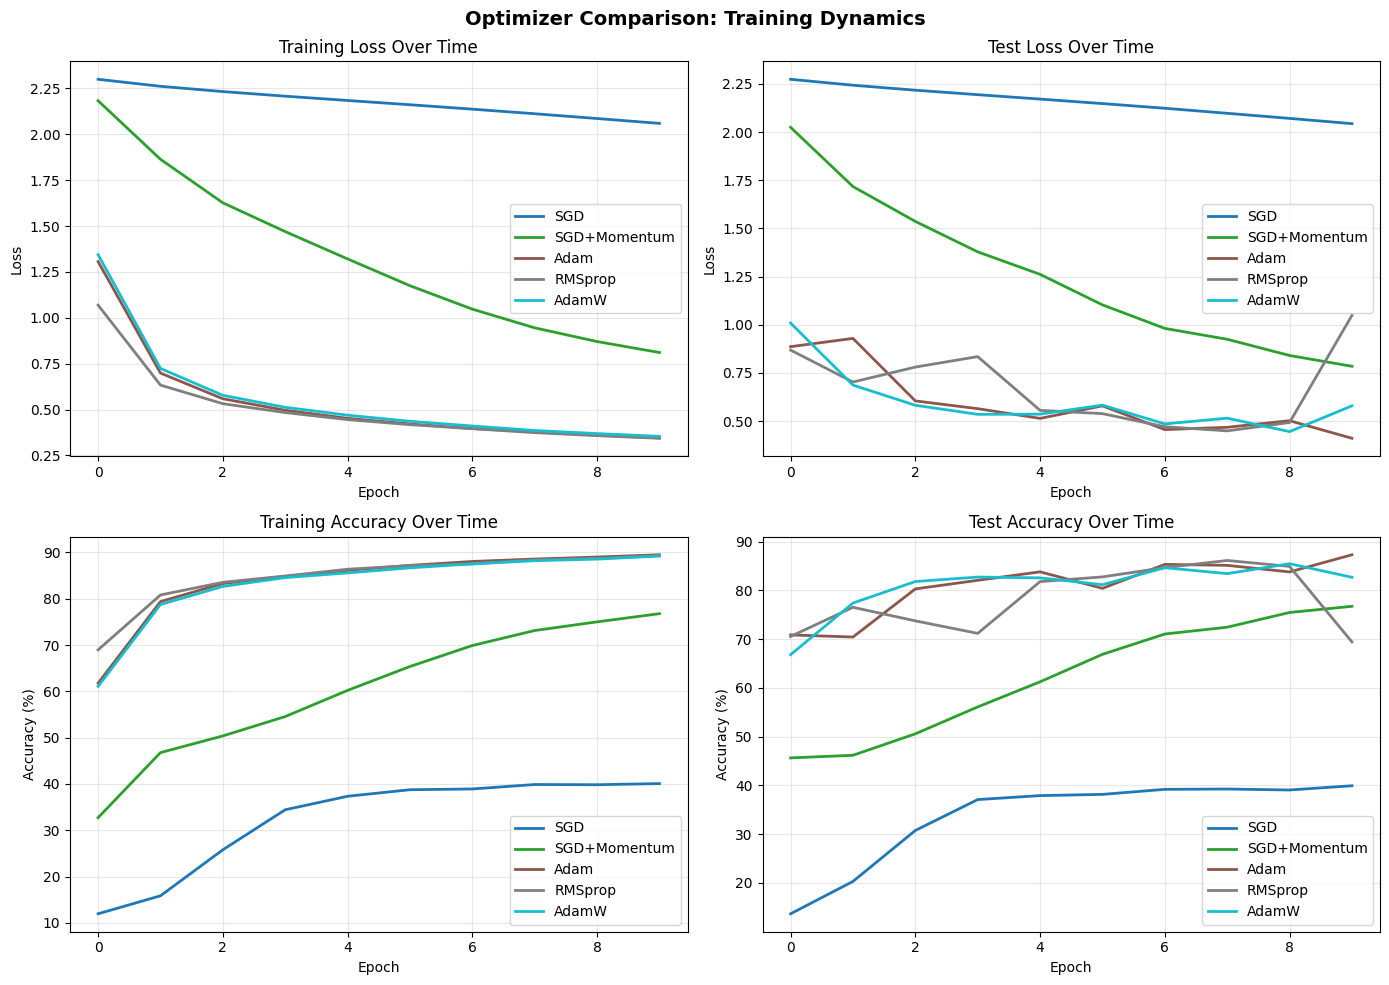

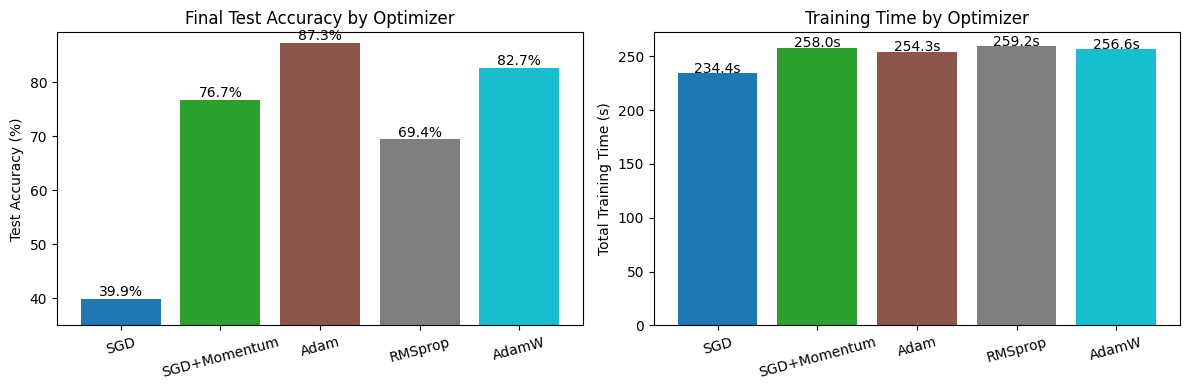


📊 OPTIMIZER COMPARISON SUMMARY
Optimizer        Final Test Acc   Best Test Acc   Total Time
----------------------------------------------------------------------
SGD                       39.9%           39.9%       234.4s
SGD+Momentum              76.7%           76.7%       258.0s
Adam                      87.3%           87.3%       254.3s
RMSprop                   69.4%           86.1%       259.2s
AdamW                     82.7%           85.5%       256.6s


In [7]:
# ============================================================
# CELL 7: Visualize Optimizer Comparison
# ============================================================

def plot_optimizer_comparison(results):
    """
    Create comprehensive visualization comparing all optimizers.

    This visualization helps understand:
    - Which optimizer converges fastest?
    - Which achieves the best final accuracy?
    - Are there signs of overfitting (train acc >> test acc)?
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    # Plot 1: Training Loss
    ax = axes[0, 0]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['train_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Test Loss
    ax = axes[0, 1]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['test_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Test Loss Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Training Accuracy
    ax = axes[1, 0]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['train_acc'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training Accuracy Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Test Accuracy
    ax = axes[1, 1]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['test_acc'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Test Accuracy Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle('Optimizer Comparison: Training Dynamics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary bar chart
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    names = list(results.keys())
    final_test_acc = [results[n]['test_acc'][-1] for n in names]
    total_time = [sum(results[n]['epoch_times']) for n in names]

    # Final accuracy comparison
    bars1 = axes[0].bar(names, final_test_acc, color=colors)
    axes[0].set_ylabel('Test Accuracy (%)')
    axes[0].set_title('Final Test Accuracy by Optimizer')
    axes[0].set_ylim([min(final_test_acc) - 5, max(final_test_acc) + 2])
    for bar, acc in zip(bars1, final_test_acc):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{acc:.1f}%', ha='center', fontsize=10)
    axes[0].tick_params(axis='x', rotation=15)

    # Training time comparison
    bars2 = axes[1].bar(names, total_time, color=colors)
    axes[1].set_ylabel('Total Training Time (s)')
    axes[1].set_title('Training Time by Optimizer')
    for bar, t in zip(bars2, total_time):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{t:.1f}s', ha='center', fontsize=10)
    axes[1].tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*70)
    print("📊 OPTIMIZER COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Optimizer':<15} {'Final Test Acc':>15} {'Best Test Acc':>15} {'Total Time':>12}")
    print("-"*70)
    for name in names:
        h = results[name]
        print(f"{name:<15} {h['test_acc'][-1]:>14.1f}% {max(h['test_acc']):>14.1f}% {sum(h['epoch_times']):>11.1f}s")
    print("="*70)


# Generate the comparison plots
plot_optimizer_comparison(optimizer_results)

---
## 🏆 Step 4: Select the Best Model for the Demo

Based on the comparison, we'll use the best-performing model for our interactive demo.

In [8]:
# ============================================================
# CELL 8: Select Best Model
# ============================================================

# Find the optimizer with the best final test accuracy
best_optimizer = max(optimizer_results.keys(),
                     key=lambda x: optimizer_results[x]['test_acc'][-1])

print(f"🏆 Best optimizer: {best_optimizer}")
print(f"   Final test accuracy: {optimizer_results[best_optimizer]['test_acc'][-1]:.1f}%")

# Use the best model for the demo
model = trained_models[best_optimizer]
model.eval()  # Set to evaluation mode

print(f"\n✅ Model ready for interactive demo!")

🏆 Best optimizer: Adam
   Final test accuracy: 87.3%

✅ Model ready for interactive demo!


---
## 🔍 Step 5: Visualization and Helper Functions

These functions help us understand what the model has learned.

In [9]:
# ============================================================
# CELL 9: Visualization Functions
# ============================================================

def preprocess_for_model(sketch):
    """
    Convert a sketch from Gradio to model input format.

    Steps:
    1. Handle different input formats (dict from Sketchpad, numpy array, PIL Image)
    2. Convert to grayscale
    3. Resize to 28x28
    4. Invert if necessary (Quick Draw uses white-on-black)
    5. Normalize to [0, 1]
    6. Convert to PyTorch tensor with batch and channel dimensions
    """
    if sketch is None:
        return None

    # Handle Gradio Sketchpad output (dictionary with 'composite' key)
    if isinstance(sketch, dict):
        img = sketch.get('composite')
    else:
        img = sketch

    if img is None:
        return None

    # Convert numpy array to PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img).convert('L')  # 'L' = grayscale

    # Resize to model input size
    img = img.resize((28, 28))

    # Convert to numpy array
    arr = np.array(img, dtype=np.float32)

    # Invert if background is white (mean > 127)
    # Quick Draw data has white drawings on black background
    if arr.mean() > 127:
        arr = 255 - arr

    # Normalize to [0, 1]
    arr = arr / 255.0

    # Add batch and channel dimensions: (28, 28) -> (1, 1, 28, 28)
    tensor = torch.FloatTensor(arr).unsqueeze(0).unsqueeze(0)

    return tensor


def predict(sketch):
    """
    Make a prediction on a sketch.

    Returns a dictionary mapping class names to probabilities.
    """
    tensor = preprocess_for_model(sketch)
    if tensor is None:
        return {}

    with torch.no_grad():
        # Get model output (logits)
        logits = model(tensor)
        # Convert to probabilities using softmax
        probs = F.softmax(logits, dim=1)[0].numpy()

    # Return as dictionary
    return {CLASSES[i]: float(probs[i]) for i in range(len(CLASSES))}


def visualize_preprocessing(sketch):
    """Show step-by-step preprocessing pipeline."""
    if sketch is None:
        return None

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Get image from sketch
    if isinstance(sketch, dict):
        img = sketch.get('composite')
    else:
        img = sketch

    if isinstance(img, np.ndarray):
        original = Image.fromarray(img)
    else:
        original = img

    # Step 1: Original
    axes[0].imshow(original)
    axes[0].set_title("1. Original Input")
    axes[0].axis('off')

    # Step 2: Grayscale
    gray = original.convert('L')
    axes[1].imshow(gray, cmap='gray')
    axes[1].set_title("2. Grayscale")
    axes[1].axis('off')

    # Step 3: Resize
    resized = gray.resize((28, 28))
    axes[2].imshow(resized, cmap='gray')
    axes[2].set_title("3. Resize (28×28)")
    axes[2].axis('off')

    # Step 4: Normalized
    arr = np.array(resized, dtype=np.float32)
    if arr.mean() > 127:
        arr = 255 - arr
    arr = arr / 255.0
    axes[3].imshow(arr, cmap='gray', vmin=0, vmax=1)
    axes[3].set_title("4. Normalized [0,1]")
    axes[3].axis('off')

    plt.suptitle("Preprocessing Pipeline: How Your Sketch Becomes Model Input", fontsize=12)
    plt.tight_layout()

    return fig


def visualize_filters(layer_name='conv1'):
    """Visualize learned convolutional filters."""
    if layer_name == 'conv1':
        weights = model.conv1.weight.detach().cpu().numpy()
    elif layer_name == 'conv2':
        weights = model.conv2.weight.detach().cpu().numpy()
    else:
        weights = model.conv3.weight.detach().cpu().numpy()

    n_filters = min(16, weights.shape[0])
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            if weights.shape[1] == 1:
                ax.imshow(weights[i, 0], cmap='RdBu', vmin=-1, vmax=1)
            else:
                ax.imshow(weights[i].mean(axis=0), cmap='RdBu', vmin=-1, vmax=1)
        ax.axis('off')

    plt.suptitle(f"Learned Filters in {layer_name}\n(Red=positive, Blue=negative weights)", fontsize=11)
    plt.tight_layout()
    return fig


def visualize_activations(sketch):
    """Show what each layer 'sees' in your sketch."""
    if sketch is None:
        return None

    tensor = preprocess_for_model(sketch)
    if tensor is None:
        return None

    with torch.no_grad():
        _ = model(tensor, store_activations=True)

    fig, axes = plt.subplots(3, 6, figsize=(12, 6))

    layer_names = ['conv1', 'conv2', 'conv3']
    titles = ['Layer 1: Edge Detection', 'Layer 2: Shape Detection', 'Layer 3: Part Detection']

    for row, (layer, title) in enumerate(zip(layer_names, titles)):
        activations = model.activations[layer][0].cpu().numpy()
        n_show = min(6, activations.shape[0])

        for col in range(6):
            if col < n_show:
                axes[row, col].imshow(activations[col], cmap='viridis')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(title, fontsize=9)

    plt.suptitle("Feature Maps: What Each Layer 'Sees'\n(Brighter = stronger activation)", fontsize=12)
    plt.tight_layout()
    return fig


def visualize_decision(sketch):
    """Show how the model makes its decision."""
    if sketch is None:
        return None

    tensor = preprocess_for_model(sketch)
    if tensor is None:
        return None

    with torch.no_grad():
        logits = model(tensor)
        logits_np = logits[0].cpu().numpy()  # Shape: (10,)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()  # Shape: (10,)

    # Sort by logit value (descending) to clearly show monotonicity
    # After sorting, both logits and probs should be in decreasing order
    sorted_indices = np.argsort(logits_np)[::-1]  # Descending order
    sorted_classes = [CLASSES[i] for i in sorted_indices]
    sorted_logits = logits_np[sorted_indices]
    sorted_probs = probs[sorted_indices]

    # Create figure with 3 subplots: input image + logits + probabilities
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Panel 0: Show the preprocessed input image
    axes[0].imshow(tensor[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title('Preprocessed Input (28×28)')
    axes[0].axis('off')

    # Panel 1: Raw logits (sorted by value)
    logit_colors = ['green' if i == 0 else 'steelblue' for i in range(len(sorted_logits))]
    axes[1].barh(sorted_classes, sorted_logits, color=logit_colors)
    axes[1].set_xlabel('Logit Value (raw score)')
    axes[1].set_title('Raw Model Output (Logits)')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].invert_yaxis()  # Highest at top

    # Panel 2: Probabilities (same sort order - should also be decreasing!)
    prob_colors = ['green' if i == 0 else 'coral' for i in range(len(sorted_probs))]
    axes[2].barh(sorted_classes, sorted_probs, color=prob_colors)
    axes[2].set_xlabel('Probability')
    axes[2].set_title('After Softmax (Probabilities)')
    axes[2].set_xlim(0, 1)
    axes[2].invert_yaxis()  # Highest at top

    # Add prediction text
    pred_class = sorted_classes[0]
    pred_prob = sorted_probs[0]
    plt.suptitle(f"Decision Process: Predicted '{pred_class}' with {pred_prob:.1%} confidence", fontsize=12)
    plt.tight_layout()
    return fig



In [10]:
# ============================================================
# CELL 10: Experiment Functions
# ============================================================

def experiment_noise(sketch, noise_level):
    """See how noise affects predictions."""
    if sketch is None:
        return None, {}

    tensor = preprocess_for_model(sketch)
    if tensor is None:
        return None, {}

    # Add Gaussian noise
    noise = torch.randn_like(tensor) * noise_level
    noisy_tensor = torch.clamp(tensor + noise, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].imshow(tensor[0, 0].numpy(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(noisy_tensor[0, 0].numpy(), cmap='gray')
    axes[1].set_title(f'With Noise (σ={noise_level:.2f})')
    axes[1].axis('off')
    plt.tight_layout()

    with torch.no_grad():
        probs = F.softmax(model(noisy_tensor), dim=1)[0].cpu().numpy()

    results = {CLASSES[i]: float(probs[i]) for i in range(len(CLASSES))}
    return fig, results


def experiment_rotation(sketch, angle):
    """See how rotation affects predictions."""
    if sketch is None:
        return None, {}

    if isinstance(sketch, dict):
        img = sketch.get('composite')
    else:
        img = sketch

    if isinstance(img, np.ndarray):
        img = Image.fromarray(img).convert('L')

    rotated = img.rotate(angle, fillcolor=255)
    rotated_resized = rotated.resize((28, 28))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(rotated_resized, cmap='gray')
    axes[1].set_title(f'Rotated {angle}°')
    axes[1].axis('off')
    plt.tight_layout()

    arr = np.array(rotated_resized, dtype=np.float32)
    if arr.mean() > 127:
        arr = 255 - arr
    tensor = torch.FloatTensor(arr / 255.0).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        probs = F.softmax(model(tensor), dim=1)[0].cpu().numpy()

    results = {CLASSES[i]: float(probs[i]) for i in range(len(CLASSES))}
    return fig, results


# Quiz questions
quiz_questions = [
    {
        "q": "What does the first convolutional layer typically learn to detect?",
        "options": ["Complete objects", "Edges and simple patterns", "Colors", "Background"],
        "answer": 1,
        "explanation": "Early layers learn low-level features like edges, corners, and simple textures. Deeper layers combine these into more complex patterns."
    },
    {
        "q": "Why do we use max pooling after convolution?",
        "options": ["To add more parameters", "To reduce spatial dimensions and provide translation invariance",
                    "To increase image resolution", "To add color"],
        "answer": 1,
        "explanation": "Max pooling reduces the spatial size and provides some translation invariance."
    },
    {
        "q": "What does the softmax function do?",
        "options": ["Makes the image softer", "Converts logits to probabilities that sum to 1",
                    "Increases model accuracy", "Reduces overfitting"],
        "answer": 1,
        "explanation": "Softmax converts raw model outputs into a probability distribution."
    },
    {
        "q": "Why might a model fail on rotated images?",
        "options": ["Rotated images have fewer pixels",
                    "CNNs aren't inherently rotation-invariant; they learn from training data orientation",
                    "The softmax doesn't work on rotated images", "Rotation changes the color"],
        "answer": 1,
        "explanation": "Standard CNNs learn features at specific orientations. Without data augmentation, they may fail on rotated inputs."
    },
    {
        "q": "What is the main advantage of Adam optimizer over basic SGD?",
        "options": ["It uses less memory", "It adapts learning rates for each parameter",
                    "It always converges faster", "It prevents all overfitting"],
        "answer": 1,
        "explanation": "Adam maintains per-parameter learning rates that adapt based on gradient history, often leading to faster convergence."
    }
]

current_quiz_idx = [0]

def get_quiz_question():
    q = quiz_questions[current_quiz_idx[0]]
    options_text = "\n".join([f"{i+1}. {opt}" for i, opt in enumerate(q["options"])])
    return f"**Question {current_quiz_idx[0]+1}/{len(quiz_questions)}:**\n\n{q['q']}\n\n{options_text}"

def check_answer(answer_num):
    if not answer_num:
        return "Please select an answer (1-4)"
    try:
        ans = int(answer_num) - 1
    except:
        return "Please enter a number 1-4"

    q = quiz_questions[current_quiz_idx[0]]
    if ans == q["answer"]:
        return f"✅ **Correct!**\n\n{q['explanation']}"
    else:
        return f"❌ **Not quite.** The correct answer is: {q['options'][q['answer']]}\n\n{q['explanation']}"

def next_question():
    current_quiz_idx[0] = (current_quiz_idx[0] + 1) % len(quiz_questions)
    return get_quiz_question(), ""

In [11]:
# ============================================================
# CELL 11: Optimizer Comparison Visualization for Gradio
# ============================================================

def create_optimizer_comparison_plot():
    """
    Create a static plot showing the optimizer comparison results.
    This will be displayed in the Gradio interface.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    colors = plt.cm.tab10(np.linspace(0, 1, len(optimizer_results)))

    # Training Loss
    for (name, history), color in zip(optimizer_results.items(), colors):
        axes[0, 0].plot(history['train_loss'], label=name, color=color, linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)

    # Test Loss
    for (name, history), color in zip(optimizer_results.items(), colors):
        axes[0, 1].plot(history['test_loss'], label=name, color=color, linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Test Loss')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)

    # Test Accuracy
    for (name, history), color in zip(optimizer_results.items(), colors):
        axes[1, 0].plot(history['test_acc'], label=name, color=color, linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Test Accuracy')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)

    # Final comparison bar chart
    names = list(optimizer_results.keys())
    final_acc = [optimizer_results[n]['test_acc'][-1] for n in names]
    bars = axes[1, 1].bar(range(len(names)), final_acc, color=colors)
    axes[1, 1].set_xticks(range(len(names)))
    axes[1, 1].set_xticklabels(names, rotation=15, ha='right')
    axes[1, 1].set_ylabel('Final Test Accuracy (%)')
    axes[1, 1].set_title('Final Performance Comparison')
    for bar, acc in zip(bars, final_acc):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                       f'{acc:.1f}%', ha='center', fontsize=9)

    plt.suptitle('Optimizer Comparison: Training Dynamics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def get_optimizer_summary():
    """
    Generate a text summary of optimizer performance.
    """
    summary = "## 📊 Optimizer Comparison Results\n\n"
    summary += "| Optimizer | Final Test Acc | Best Test Acc | Training Time |\n"
    summary += "|-----------|----------------|---------------|---------------|\n"

    for name, history in optimizer_results.items():
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        total_time = sum(history['epoch_times'])
        summary += f"| {name} | {final_acc:.1f}% | {best_acc:.1f}% | {total_time:.1f}s |\n"

    # Add best optimizer
    best = max(optimizer_results.keys(), key=lambda x: optimizer_results[x]['test_acc'][-1])
    summary += f"\n**🏆 Best Optimizer: {best}** (currently in use for predictions)"

    return summary

---
## 🌐 Step 6: Build the Interactive Gradio Interface

Now we create an interactive web interface where you can:
1. Draw sketches and get real-time predictions
2. Explore the preprocessing pipeline
3. Visualize what the CNN layers see
4. **NEW:** Compare different optimizer performance
5. Test model robustness to noise and rotation
6. Take a quiz to test your understanding

In [ ]:
# ============================================================
# CELL 12: Build Gradio Interface
# ============================================================

with gr.Blocks(title="CNN Learning Lab", theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # 🎓 CNN Learning Lab: Understanding Image Classification

    This interactive demo helps you understand how Convolutional Neural Networks (CNNs)
    process and classify images. Draw sketches and explore what's happening inside the model!

    **Model trained on Quick Draw dataset with 10 classes.**
    """)

    with gr.Tabs():

        # -------- TAB 1: Draw & Predict --------
        with gr.TabItem("1️⃣ Draw & Predict"):
            gr.Markdown("""
            ### Start Here: Draw Something!
            Draw one of these classes: **cat, dog, house, tree, car, sun, flower, bird, fish, star**
            """)

            with gr.Row():
                canvas = gr.Sketchpad(
                    label="Your Drawing",
                    brush=gr.Brush(colors=["#000"], default_size=6),
                    height=300
                )
                output = gr.Label(label="Model Predictions", num_top_classes=5)

            canvas.change(predict, canvas, output)

        # -------- TAB 2: Optimizer Comparison (NEW!) --------
        with gr.TabItem("2️⃣ Optimizer Comparison"):
            gr.Markdown("""
            ### 🔧 How Different Optimizers Affect Training

            We trained the same CNN architecture with 5 different optimizers.
            Each optimizer has a different strategy for updating the model weights.

            **Key Observations to Make:**
            - Which optimizer converges fastest? (steepest initial drop in loss)
            - Which achieves the best final accuracy?
            - Do any show signs of overfitting? (train acc much higher than test acc)
            """)

            # Show the comparison plot
            optimizer_plot = gr.Plot(label="Optimizer Training Comparison")
            refresh_btn = gr.Button("Show/Refresh Comparison")
            refresh_btn.click(create_optimizer_comparison_plot, outputs=optimizer_plot)

            # Show summary table
            summary_md = gr.Markdown(get_optimizer_summary())

            gr.Markdown("""
            ### 📖 Optimizer Quick Reference

            | Optimizer | How it Works | Best For |
            |-----------|--------------|----------|
            | **SGD** | Fixed learning rate, simple updates | When you need good generalization |
            | **SGD+Momentum** | Adds "velocity" to updates | Faster than SGD, smoother convergence |
            | **Adam** | Adapts learning rate per parameter | General purpose, fast convergence |
            | **RMSprop** | Adapts based on recent gradient magnitudes | Recurrent networks, non-stationary |
            | **AdamW** | Adam with proper weight decay | Better generalization than Adam |
            """)

        # -------- TAB 3: Preprocessing --------
        with gr.TabItem("3️⃣ Preprocessing Pipeline"):
            gr.Markdown("""
            ### How Your Drawing Becomes Model Input

            Before a neural network can process your sketch, it goes through several
            preprocessing steps.

            **Key Concepts:**
            - **Grayscale**: Reduces complexity (1 channel vs 3)
            - **Resize**: Fixed input size required by the model
            - **Normalize**: Scale pixel values to [0,1] for stable training
            """)

            with gr.Row():
                preprocess_canvas = gr.Sketchpad(
                    brush=gr.Brush(colors=["#000"], default_size=6),
                    height=250
                )
                preprocess_plot = gr.Plot(label="Preprocessing Steps")

            preprocess_btn = gr.Button("Show Preprocessing Pipeline")
            preprocess_btn.click(visualize_preprocessing, preprocess_canvas, preprocess_plot)

        # -------- TAB 4: Inside the CNN --------
        with gr.TabItem("4️⃣ Inside the CNN"):
            gr.Markdown("""
            ### What Does Each Layer See?

            CNNs build up representations hierarchically:
            - **Layer 1**: Detects edges, corners, simple textures
            - **Layer 2**: Combines edges into shapes (curves, angles)
            - **Layer 3**: Recognizes parts (eyes, wheels, leaves)
            """)

            with gr.Row():
                activation_canvas = gr.Sketchpad(
                    brush=gr.Brush(colors=["#000"], default_size=6),
                    height=250
                )
                activation_plot = gr.Plot(label="Layer Activations")

            activation_btn = gr.Button("Visualize Feature Maps")
            activation_btn.click(visualize_activations, activation_canvas, activation_plot)

            gr.Markdown("### Learned Filters")
            filter_dropdown = gr.Dropdown(
                choices=['conv1', 'conv2', 'conv3'],
                value='conv1',
                label="Select Layer"
            )
            filter_plot = gr.Plot(label="Convolutional Filters")
            filter_btn = gr.Button("Show Filters")
            filter_btn.click(visualize_filters, filter_dropdown, filter_plot)

        # -------- TAB 5: Decision Process --------
        with gr.TabItem("5️⃣ Making Decisions"):
            gr.Markdown("""
            ### From Features to Predictions

            After extracting features, the network must make a decision:

            1. **Logits**: Raw scores for each class (can be any number)
            2. **Softmax**: Converts logits to probabilities (0-1, sum to 1)
            3. **Prediction**: Class with highest probability wins

            **The softmax formula:** `P(class_i) = exp(logit_i) / Σ exp(logit_j)`
            """)

            with gr.Row():
                decision_canvas = gr.Sketchpad(
                    brush=gr.Brush(colors=["#000"], default_size=6),
                    height=250
                )
                decision_plot = gr.Plot(label="Decision Visualization")

            decision_btn = gr.Button("Show Decision Process")
            decision_btn.click(visualize_decision, decision_canvas, decision_plot)

        # -------- TAB 6: Experiments --------
        with gr.TabItem("6️⃣ Experiments"):
            gr.Markdown("""
            ### Explore Model Robustness

            Real-world inputs aren't perfect. How does the model handle variations?
            """)

            with gr.Accordion("🔊 Noise Experiment", open=True):
                gr.Markdown("**Question:** How much noise can the model tolerate?")
                with gr.Row():
                    noise_canvas = gr.Sketchpad(
                        brush=gr.Brush(colors=["#000"], default_size=6),
                        height=200
                    )
                    noise_slider = gr.Slider(0, 0.5, value=0.1, step=0.05, label="Noise Level (σ)")
                with gr.Row():
                    noise_plot = gr.Plot()
                    noise_output = gr.Label(num_top_classes=3)
                noise_btn = gr.Button("Add Noise & Predict")
                noise_btn.click(experiment_noise, [noise_canvas, noise_slider], [noise_plot, noise_output])

            with gr.Accordion("🔄 Rotation Experiment", open=True):
                gr.Markdown("**Question:** Are CNNs rotation-invariant?")
                with gr.Row():
                    rotation_canvas = gr.Sketchpad(
                        brush=gr.Brush(colors=["#000"], default_size=6),
                        height=200
                    )
                    rotation_slider = gr.Slider(-180, 180, value=0, step=15, label="Rotation Angle (°)")
                with gr.Row():
                    rotation_plot = gr.Plot()
                    rotation_output = gr.Label(num_top_classes=3)
                rotation_btn = gr.Button("Rotate & Predict")
                rotation_btn.click(experiment_rotation, [rotation_canvas, rotation_slider],
                                   [rotation_plot, rotation_output])

        # -------- TAB 7: Quiz --------
        with gr.TabItem("7️⃣ Knowledge Check"):
            gr.Markdown("### Test Your Understanding")

            quiz_display = gr.Markdown(get_quiz_question())
            answer_input = gr.Textbox(label="Your Answer (1-4)", placeholder="Enter 1, 2, 3, or 4")

            with gr.Row():
                check_btn = gr.Button("Check Answer", variant="primary")
                next_btn = gr.Button("Next Question")

            result_display = gr.Markdown("")

            check_btn.click(check_answer, answer_input, result_display)
            next_btn.click(next_question, outputs=[quiz_display, result_display])

        # -------- TAB 8: Architecture Reference --------
        with gr.TabItem("📐 Architecture"):
            gr.Markdown("""
            ### Model Architecture
            ```
            Input: 28×28×1 (grayscale image)
                    ↓
            ┌─────────────────────────────────────┐
            │ Conv Layer 1                        │
            │ • 16 filters, 3×3 kernel            │
            │ • BatchNorm + ReLU                  │
            │ • MaxPool 2×2 → Output: 14×14×16    │
            └─────────────────────────────────────┘
                    ↓
            ┌─────────────────────────────────────┐
            │ Conv Layer 2                        │
            │ • 32 filters, 3×3 kernel            │
            │ • BatchNorm + ReLU                  │
            │ • MaxPool 2×2 → Output: 7×7×32      │
            └─────────────────────────────────────┘
                    ↓
            ┌─────────────────────────────────────┐
            │ Conv Layer 3                        │
            │ • 64 filters, 3×3 kernel            │
            │ • BatchNorm + ReLU                  │
            │ • GlobalAvgPool → Output: 1×1×64    │
            └─────────────────────────────────────┘
                    ↓
            ┌─────────────────────────────────────┐
            │ Fully Connected                     │
            │ • 64 → 10 classes                   │
            │ • Softmax for probabilities         │
            └─────────────────────────────────────┘
                    ↓
            Output: 10 class probabilities
            ```

            ### Key Concepts Glossary

            | Term | Definition |
            |------|------------|
            | **Convolution** | Sliding a small filter across the image to detect local patterns |
            | **Feature Map** | Output of a convolutional layer; shows where features are detected |
            | **ReLU** | Activation function: max(0, x). Introduces non-linearity |
            | **MaxPool** | Downsampling by taking the maximum value in each region |
            | **BatchNorm** | Normalizes layer inputs for faster, more stable training |
            | **Softmax** | Converts logits to probabilities that sum to 1 |
            | **Optimizer** | Algorithm that updates weights based on gradients (SGD, Adam, etc.) |
            """)

    gr.Markdown("""
    ---
    ### 📚 Further Learning
    - [CS231n: CNNs for Visual Recognition](http://cs231n.stanford.edu/)
    - [3Blue1Brown: Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
    - [PyTorch Tutorials](https://pytorch.org/tutorials/)
    """)

# Launch the demo
demo.launch(share=True, debug=True)

/tmp/ipython-input-701038574.py:5: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="CNN Learning Lab", theme=gr.themes.Soft()) as demo:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2c419ecadcf9641735.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


content_type multipart/form-data; boundary=----WebKitFormBoundaryuDZq1uKrjdKGImuE
content_type multipart/form-data; boundary=----WebKitFormBoundaryhjrCqIJBGKibjasf
content_type multipart/form-data; boundary=----WebKitFormBoundary2FqSXTFews1fJBTs
content_type multipart/form-data; boundary=----WebKitFormBoundaryXQiQt2JB8IgEAWjG
content_type multipart/form-data; boundary=----WebKitFormBoundarySdr08iw6CNG183Gg
content_type multipart/form-data; boundary=----WebKitFormBoundaryA9KePjOFYzBZOgC7
content_type multipart/form-data; boundary=----WebKitFormBoundarywvGsAmMy6qn9UFyA
content_type multipart/form-data; boundary=----WebKitFormBoundarylJ2QjkVqSmAkMMRW
content_type multipart/form-data; boundary=----WebKitFormBoundarygnxDnVwoFAdyjLrg
content_type multipart/form-data; boundary=----WebKitFormBoundaryjuApsw5OOEhNDos2
content_type multipart/form-data; boundary=----WebKitFormBoundarye28YDZqWRDbXbfSt
content_type multipart/form-data; boundary=----WebKitFormBoundaryYEN2lLmfu2NejzrQ
content_type mul

---
## 📚 Summary

In this notebook, we covered the complete ML pipeline:

1. **Data Loading**: Downloaded and prepared the Quick Draw dataset
2. **Model Definition**: Built a 3-layer CNN for image classification
3. **Training with Multiple Optimizers**: Compared SGD, SGD+Momentum, Adam, RMSprop, and AdamW
4. **Evaluation**: Tracked training/test loss and accuracy over epochs
5. **Visualization**: Explored what the CNN learns at each layer
6. **Deployment**: Built an interactive Gradio interface

### Key Takeaways:

- **Train/Test Split** is crucial for measuring generalization
- **Optimizers matter**: Adam often converges faster, but SGD may generalize better
- **CNNs learn hierarchically**: edges → shapes → parts → objects
- **Preprocessing** is essential: normalize, resize, handle color channels
- **Softmax** converts raw scores to interpretable probabilities